# Importing all the necessary libraries and Dataset

In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv(r"D:\Stuff\CyberSec\Datasets\IDS2018\02-14-2018_processed.csv")
print (data.shape)
print (data.tail())
print (data.columns)

## Taking feature and Label columns

In [2]:
X = data.drop(["Label"],axis=1)
y = data["Label"] 
n_cols = data.shape[1]

### Checking if the dataset is clean or not by applying some classfier

In [3]:
X_true_train, X_true_test, y_true_train, y_true_test = train_test_split(X, y, test_size=0.30, random_state=42)
clf_true = RandomForestClassifier(n_estimators=100)
clf_true.fit(X_true_train,y_true_train)
y_true_pred=clf_true.predict(X_true_test)
print("Base Accuracy:",metrics.accuracy_score(y_true_test, y_true_pred))
print("Base classification report:",metrics.classification_report(y_true_test, y_true_pred))

Base Accuracy: 0.9999585229049281
Base classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00    199116
           1       1.00      1.00      1.00     57831
           2       1.00      1.00      1.00     56479

    accuracy                           1.00    313426
   macro avg       1.00      1.00      1.00    313426
weighted avg       1.00      1.00      1.00    313426



---
# GAN Train Model
## Defining functions for GAN Model

In [4]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [5]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [6]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = data.sample(n)
    y = np.ones((n, 1))
    return X, y

In [7]:
def define_generator(latent_dim, n_outputs=n_cols):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(n_outputs, activation='linear'))
    return model


In [8]:
generator1 = define_generator(10, n_cols)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                165       
                                                                 
 dense_1 (Dense)             (None, 30)                480       
                                                                 
 dense_2 (Dense)             (None, 66)                2046      
                                                                 
Total params: 2,691
Trainable params: 2,691
Non-trainable params: 0
_________________________________________________________________


In [9]:
def define_discriminator(n_inputs=n_cols):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [10]:
discriminator1 = define_discriminator(n_cols)
discriminator1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 25)                1675      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [15]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist, epoch, first_epoch, last_epoch):
    # plot loss
    if epoch == first_epoch or epoch == last_epoch or (epoch > first_epoch and epoch < last_epoch and epoch % 50 == 0):
        plt.subplot(1, 1, 1)
        plt.plot(d_hist, label='d')
        plt.plot(g_hist, label='gen')
        plt.title('Epoch {}'.format(epoch))
        plt.legend()
        plt.show()
        plt.close()


## Training the GAN Model and exporting the Model

2/2 [==============================] - 0s 2ms/step


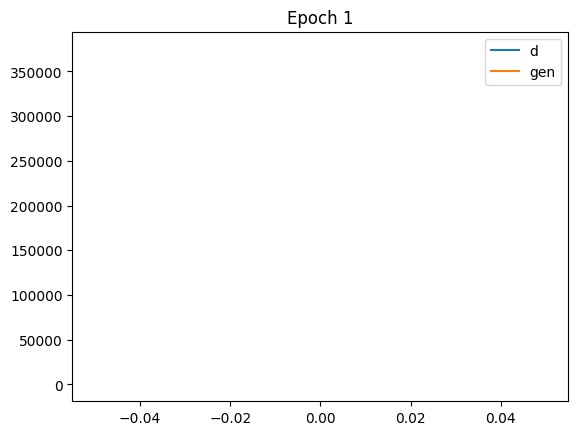

2/2 [==============================] - 0s 2ms/step


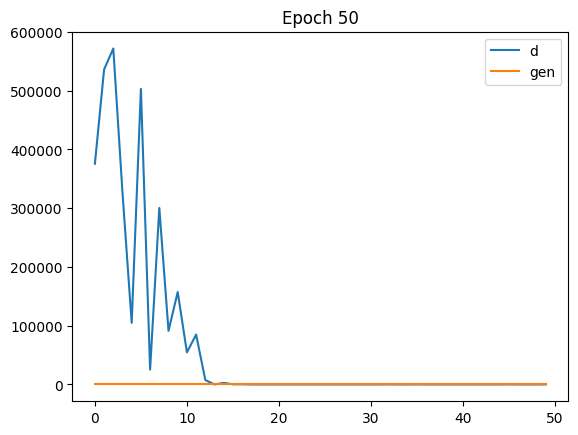

2/2 [==============================] - 0s 1ms/step


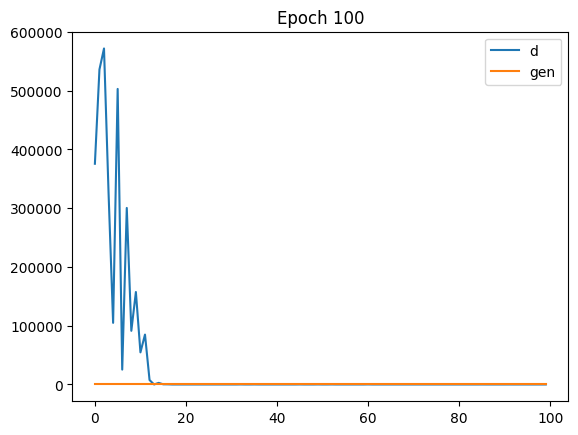

2/2 [==============================] - 0s 3ms/step


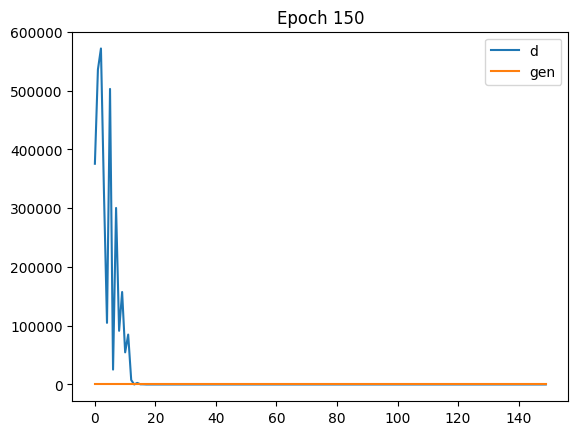

2/2 [==============================] - 0s 2ms/step


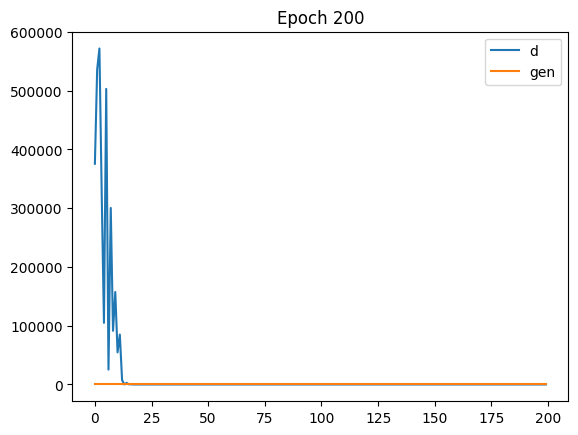

2/2 [==============================] - 0s 2ms/step


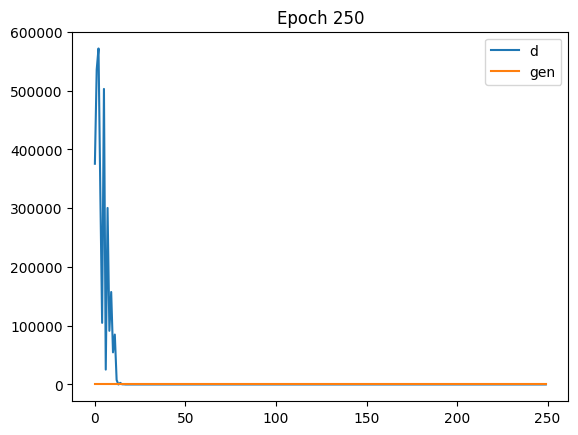

2/2 [==============================] - 0s 2ms/step


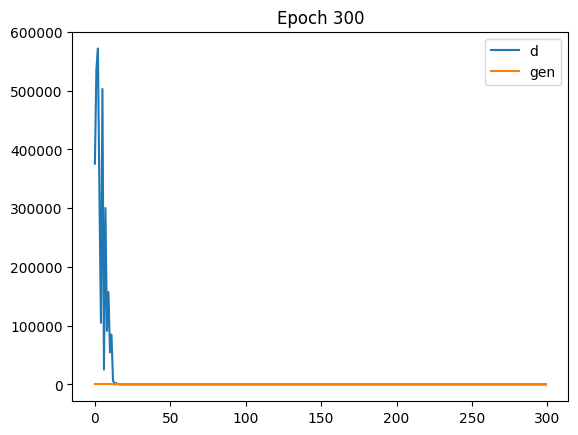

2/2 [==============================] - 0s 2ms/step


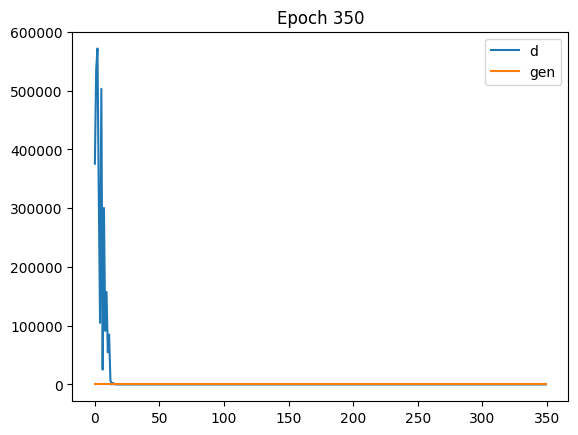

2/2 [==============================] - 0s 999us/step


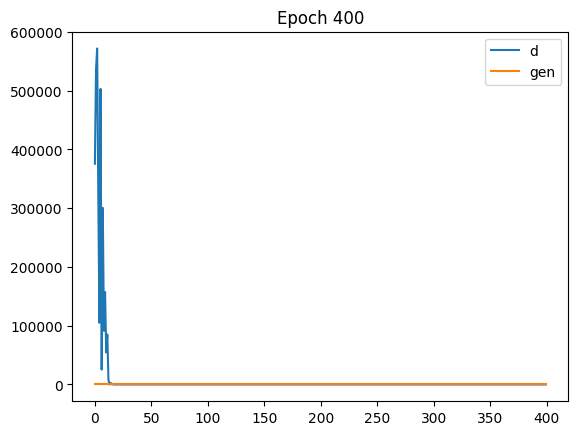

2/2 [==============================] - 0s 2ms/step


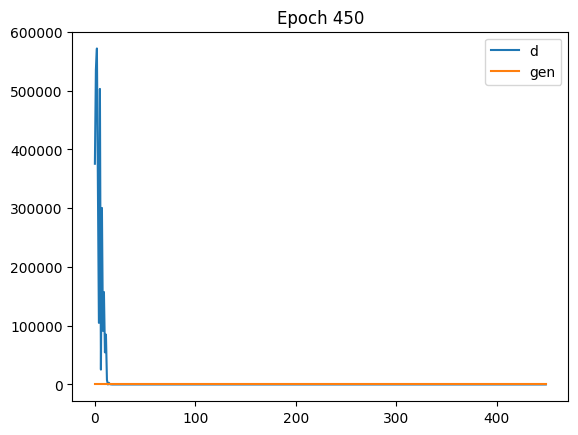

2/2 [==============================] - 0s 2ms/step


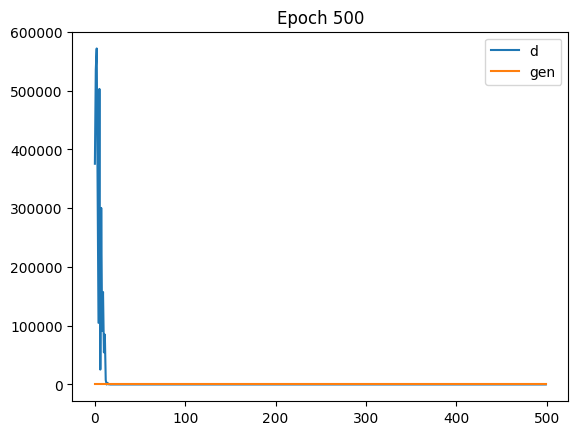

Final Epoch: d1=0.000, d2=12.924 d=6.462 g=0.001


In [16]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=500, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    first_epoch = 1
    last_epoch = n_epochs
    # manually enumerate epochs
    for epoch in range(1, n_epochs+1):
            # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
        d_history.append(d_loss)
        g_history.append(g_loss_fake)
        plot_history(d_history, g_history, epoch, first_epoch, last_epoch)
        if epoch == n_epochs:
            print('Final Epoch: d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
            g_model.save('trained_generated_model.h5')


# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

---
# Generating Synthetic Data
## Importing Model and Fixing latent points

In [17]:
from keras.models import load_model
model =load_model("trained_generated_model.h5")

In [18]:
latent_points = generate_latent_points(10, 750)
X = model.predict(latent_points)

column_names = list(data.columns)
data_fake = pd.DataFrame(data=X,  columns=column_names)
data_fake.head()

24/24 [==============================] - 0s 1ms/step


,Dst Port,Protocol,Flow Duration,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-6.893476,-1.459603,-6.719600,-0.380562,1.967473,4.011272,-0.222250,-0.906830,-0.357459,-1.339277,...,-1.162111,8.705583,0.965976,-7.632451,7.862384,8.642303,-0.505761,-6.530869,7.957932,-0.643741
1,-6.969390,-1.483662,-7.332975,-0.548718,2.040759,3.823230,-0.534663,-0.876954,-0.375230,-1.348700,...,-1.294337,8.626342,1.020795,-7.466700,8.268419,8.925119,-0.617429,-6.293451,8.707560,-0.891812
2,-5.439129,-0.668019,-5.363421,-0.471890,1.684991,3.505449,-0.259639,-0.816013,-0.593033,-0.872635,...,-1.165932,7.192151,0.381619,-6.842743,6.789179,7.235950,-0.824484,-5.189060,7.016349,-0.882918
3,-7.842204,-2.732012,-7.627914,-1.051129,2.256195,4.759822,-0.391575,-0.717128,-0.036811,-1.554748,...,-0.755705,10.244387,0.984932,-9.046252,9.436084,8.901787,-1.374413,-8.579399,9.033251,-0.976591
4,-6.361454,-2.060133,-5.969363,-0.781120,2.205397,3.805883,-0.333874,-0.730844,-0.203610,-0.858788,...,-0.422057,8.057696,0.388571,-7.657500,7.617271,7.490529,-1.337391,-6.491331,7.067005,-1.003561


In [19]:
outcome_mean = data_fake.Label.mean()
data_fake['Label'] = data_fake['Label'] > outcome_mean
data_fake["Label"] = data_fake["Label"].astype(int)

In [20]:
column_names = list(data.columns)
column_names.pop()

features = column_names
label = ['Label']
X_fake_created = data_fake[features]
y_fake_created = data_fake[label]

### See the Metrics of Synthetic data

In [28]:
X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(X_fake_created, y_fake_created, test_size=0.30, random_state=42)
clf_fake = RandomForestClassifier(n_estimators=100)
clf_fake.fit(X_fake_train,y_fake_train)
y_fake_pred=clf_fake.predict(X_fake_test)
print("Accuracy of fake data model:",metrics.accuracy_score(y_fake_test, y_fake_pred))
print("Classification report of fake data model:",metrics.classification_report(y_fake_test, y_fake_pred))

Accuracy of fake data model: 0.9155555555555556
Classification report of fake data model:               precision    recall  f1-score   support

           0       0.91      0.91      0.91       106
           1       0.92      0.92      0.92       119

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.92      0.92      0.92       225



### Evaluating Synthetic Data with Classifiers

In [27]:
from table_evaluator import load_data, TableEvaluator
table_evaluator = TableEvaluator(data, data_fake)
table_evaluator.evaluate(target_col='Label')


Classifier F1-scores and their Jaccard similarities::
                             f1_real  f1_fake  jaccard_similarity
index                                                            
DecisionTreeClassifier_fake   0.4200   0.8600              0.2821
DecisionTreeClassifier_real   1.0000   0.2000              0.1111
LogisticRegression_fake       0.5800   0.9667              0.4151
LogisticRegression_real       0.9733   0.2533              0.1450
MLPClassifier_fake            0.5800   0.9133              0.3636
MLPClassifier_real            0.9933   0.5467              0.3761
RandomForestClassifier_fake   0.4200   0.8333              0.3158
RandomForestClassifier_real   1.0000   0.4067              0.2552

Privacy results:
                                           result
Duplicate rows between sets (real/fake)  (204, 0)
nearest neighbor mean                      6.9449
nearest neighbor std                       4.3594

Miscellaneous results:
                                  Result
Co

---
# Export the Synthetic Data into a CSV File

In [ ]:
data_fake.to_csv('generated_data.csv', index=False)